In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler 
import lightgbm as lgbm
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier

# import pycaret library for binary classification 
from pycaret.classification import *
import pycaret

In [2]:
#setup train and test dataframes 
train = pd.read_csv('train.csv') 
test = pd.read_csv('test_x.csv') 
submission = pd.read_csv('sample_submission.csv') 

train = train.drop(columns=['index']) 
test = test.drop(columns=['index'])

# Flip columns and add Mach score

In [3]:
flipping_columns = ["QeA","QfA","QkA","QqA","QrA","QaA","QdA","QgA","QiA","QnA"] 
for flip in flipping_columns: 
    train[flip] = 6 - train[flip] 

<AxesSubplot:>

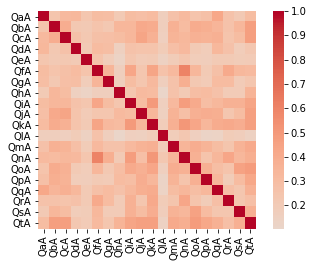

In [4]:
Answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
             'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
             'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
             'QpA', 'QqA', 'QrA', 'QsA', 'QtA']

correlations = train[Answers].corr(method = "spearman") 
sns.heatmap(correlations, cmap="coolwarm", square = True, center = 0)

In [5]:
train['Mach_score'] = train[Answers].mean(axis = 1) 
train.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13,Mach_score
0,3.0,363,4.0,1370,5.0,997,5.0,1024,4.0,1577,...,1,0,1,1,0,1,0,1,1,2.95
1,1.0,647,5.0,1313,3.0,3387,1.0,2969,5.0,4320,...,1,0,1,1,0,1,0,1,1,2.60
2,2.0,1623,1.0,1480,1.0,1021,2.0,3374,1.0,1333,...,1,0,1,1,1,1,0,1,1,1.90
3,3.0,504,3.0,2311,4.0,992,3.0,3245,5.0,357,...,0,0,0,1,0,1,0,1,1,3.35
4,5.0,927,1.0,707,5.0,556,4.0,1062,5.0,1014,...,1,1,1,1,0,1,1,1,1,3.00


In [6]:
train[['Mach_score']].describe()

,Mach_score
count,45532.000000
mean,3.352474
std,0.794661
min,1.000000
25%,2.750000
50%,3.350000
75%,3.950000
max,5.000000


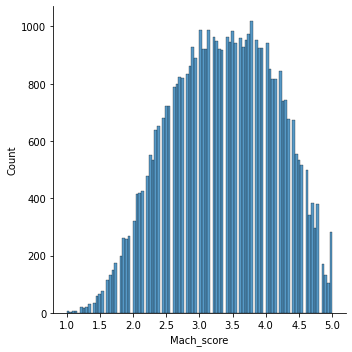

In [7]:
sns.displot(train, x = "Mach_score", bins = 100)

In [8]:
flipping_columns = ["QeA","QfA","QkA","QqA","QrA","QaA","QdA","QgA","QiA","QnA"] 
for flip in flipping_columns: 
    test[flip] = 6 - test[flip] 

<AxesSubplot:>

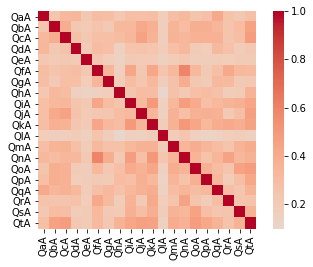

In [9]:
Answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
             'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
             'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
             'QpA', 'QqA', 'QrA', 'QsA', 'QtA']

correlations = test[Answers].corr(method = "spearman") 
sns.heatmap(correlations, cmap="coolwarm", square = True, center = 0)

In [10]:
test['Mach_score'] = test[Answers].mean(axis = 1) 
test.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13,Mach_score
0,3.0,736,2.0,2941,3.0,4621,5.0,4857,4.0,2550,...,1,0,0,1,0,1,0,1,1,2.45
1,3.0,514,2.0,1952,3.0,1552,3.0,821,2.0,1150,...,0,0,0,0,0,0,0,0,0,2.80
2,3.0,500,2.0,2507,4.0,480,4.0,614,4.0,1326,...,1,0,1,1,0,1,0,1,1,3.55
3,5.0,669,1.0,1050,5.0,1435,4.0,2252,1.0,2533,...,1,1,1,1,1,1,1,1,1,3.35
4,4.0,499,1.0,1243,5.0,845,4.0,1666,4.0,925,...,1,0,1,1,0,1,1,1,1,2.90


# Fit model using pycaret

In [11]:
clf = setup(data = train, target = 'voted')

Setup Succesfully Completed!


,Description,Value
0,session_id,689
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45532, 78)"
4,Missing Values,False
5,Numeric Features,42
6,Categorical Features,35
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


# Light GBM

In [12]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7023,0.7738,0.6649,0.7605,0.7095,0.4071,0.4109
1,0.7023,0.7634,0.6575,0.7650,0.7072,0.4080,0.4128
2,0.6934,0.7581,0.6452,0.7579,0.6971,0.3908,0.3960
3,0.6919,0.7623,0.6470,0.7544,0.6965,0.3873,0.3920
4,0.6994,0.7636,0.6431,0.7694,0.7006,0.4036,0.4102
5,0.6894,0.7590,0.6368,0.7566,0.6916,0.3833,0.3891
6,0.6912,0.7640,0.6483,0.7528,0.6967,0.3858,0.3903
7,0.6994,0.7700,0.6517,0.7640,0.7034,0.4026,0.4078
8,0.6903,0.7596,0.6328,0.7607,0.6909,0.3858,0.3924
9,0.6916,0.7601,0.6472,0.7540,0.6965,0.3866,0.3913


In [13]:
tuned_lgbm = tune_model(lgbm, n_iter = 100, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7077,0.7759,0.6592,0.7727,0.7115,0.4190,0.4244
1,0.7061,0.7664,0.6472,0.7779,0.7065,0.4171,0.4242
2,0.6872,0.7573,0.6303,0.7567,0.6878,0.3795,0.3859
3,0.6994,0.7624,0.6418,0.7700,0.7001,0.4037,0.4105
4,0.7003,0.7630,0.6363,0.7755,0.6990,0.4064,0.4143
5,0.6912,0.7627,0.6305,0.7637,0.6908,0.3881,0.3952
6,0.6881,0.7612,0.6305,0.7585,0.6886,0.3815,0.3880
7,0.7000,0.7698,0.6408,0.7719,0.7003,0.4052,0.4122
8,0.6931,0.7647,0.6328,0.7654,0.6928,0.3917,0.3988
9,0.6916,0.7620,0.6460,0.7547,0.6961,0.3868,0.3916


In [14]:
calibrated_lgbm = calibrate_model(tuned_lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7042,0.7764,0.6695,0.7608,0.7122,0.4105,0.4140
1,0.7073,0.7669,0.6649,0.7686,0.7130,0.4176,0.4222
2,0.6887,0.7604,0.6504,0.7474,0.6955,0.3803,0.3841
3,0.6950,0.7641,0.6538,0.7553,0.7009,0.3931,0.3973
4,0.6966,0.7663,0.6483,0.7615,0.7003,0.3970,0.4023
5,0.6975,0.7654,0.6495,0.7623,0.7014,0.3989,0.4041
6,0.6878,0.7659,0.6500,0.7464,0.6949,0.3784,0.3821
7,0.7003,0.7714,0.6615,0.7596,0.7071,0.4033,0.4074
8,0.6912,0.7641,0.6431,0.7559,0.6950,0.3865,0.3917
9,0.6928,0.7653,0.6609,0.7481,0.7018,0.3876,0.3907


In [15]:
predict_holdout = predict_model(calibrated_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Calibrated Classifier C V,0.6989,0.771,0.6582,0.7591,0.7051,0.4007,0.405


# Extra Trees Classifier

In [16]:
et = create_model('et') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7023,0.7731,0.6690,0.7581,0.7108,0.4066,0.4100
1,0.6945,0.7564,0.6558,0.7535,0.7012,0.3917,0.3957
2,0.6781,0.7491,0.6383,0.7374,0.6843,0.3593,0.3632
3,0.6975,0.7615,0.6464,0.7639,0.7002,0.3992,0.4049
4,0.6884,0.7603,0.6357,0.7558,0.6906,0.3815,0.3873
5,0.6950,0.7555,0.6426,0.7624,0.6974,0.3945,0.4003
6,0.6859,0.7563,0.6449,0.7463,0.6919,0.3750,0.3792
7,0.6912,0.7679,0.6443,0.7552,0.6954,0.3863,0.3914
8,0.6887,0.7587,0.6328,0.7581,0.6898,0.3825,0.3888
9,0.6906,0.7579,0.6500,0.7508,0.6968,0.3843,0.3885


In [19]:
calibrated_et = calibrate_model(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7089,0.7782,0.6753,0.7648,0.7172,0.4197,0.4231
1,0.7008,0.7653,0.6678,0.7563,0.7093,0.4034,0.4068
2,0.6865,0.7552,0.6504,0.7439,0.6940,0.3757,0.3792
3,0.6988,0.7651,0.6619,0.7566,0.7061,0.4000,0.4038
4,0.6956,0.7622,0.6495,0.7592,0.7001,0.3949,0.3999
5,0.6972,0.7648,0.6575,0.7569,0.7037,0.3972,0.4014
6,0.6872,0.7571,0.6581,0.7410,0.6971,0.3760,0.3788
7,0.6966,0.7735,0.6627,0.7529,0.7049,0.3953,0.3987
8,0.6947,0.7668,0.6483,0.7584,0.6990,0.3931,0.3981
9,0.6894,0.7630,0.6695,0.7381,0.7022,0.3792,0.3812


In [20]:
predict_holdout = predict_model(calibrated_et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Calibrated Classifier C V,0.6953,0.7677,0.6639,0.7502,0.7044,0.3925,0.3956


# Create Random Forest

In [21]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6625,0.7226,0.6322,0.7170,0.6720,0.3272,0.3300
1,0.6531,0.7135,0.5984,0.7198,0.6535,0.3120,0.3174
2,0.6445,0.7034,0.5913,0.7099,0.6452,0.2949,0.2998
3,0.6586,0.7202,0.6028,0.7261,0.6587,0.3231,0.3287
4,0.6486,0.7063,0.5938,0.7153,0.6489,0.3032,0.3084
5,0.6492,0.7069,0.5927,0.7169,0.6489,0.3046,0.3102
6,0.6501,0.7063,0.5950,0.7172,0.6504,0.3063,0.3117
7,0.6709,0.7266,0.6242,0.7341,0.6747,0.3460,0.3507
8,0.6514,0.7009,0.5846,0.7248,0.6472,0.3104,0.3174
9,0.6445,0.6962,0.5995,0.7061,0.6485,0.2937,0.2977


In [22]:
tuned_rf = tune_model(rf, n_iter = 100, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6960,0.7673,0.6581,0.7546,0.7030,0.3947,0.3986
1,0.7001,0.7572,0.6443,0.7697,0.7014,0.4050,0.4114
2,0.6869,0.7550,0.6389,0.7510,0.6904,0.3778,0.3828
3,0.6944,0.7625,0.6435,0.7605,0.6971,0.3930,0.3986
4,0.6928,0.7589,0.6288,0.7675,0.6913,0.3916,0.3993
5,0.6916,0.7605,0.6363,0.7606,0.6929,0.3880,0.3943
6,0.6875,0.7582,0.6357,0.7543,0.6899,0.3795,0.3852
7,0.6938,0.7684,0.6431,0.7600,0.6967,0.3918,0.3973
8,0.6969,0.7647,0.6317,0.7726,0.6951,0.3997,0.4078
9,0.6843,0.7556,0.6397,0.7468,0.6891,0.3724,0.3770


In [ ]:
calibrated_rf = calibrate_model(tuned_rf) 

In [24]:
predict_holdout = predict_model(calibrated_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Calibrated Classifier C V,0.6969,0.7698,0.656,0.7572,0.703,0.3967,0.4009


# Catboost 

In [25]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7045,0.7718,0.6741,0.7586,0.7139,0.4106,0.4136
1,0.7042,0.7676,0.6713,0.7597,0.7128,0.4103,0.4136
2,0.6872,0.7598,0.6458,0.7475,0.6929,0.3776,0.3818
3,0.6894,0.7623,0.6550,0.7458,0.6974,0.3810,0.3844
4,0.6909,0.7647,0.6454,0.7540,0.6955,0.3855,0.3904
5,0.6944,0.7584,0.6512,0.7562,0.6998,0.3921,0.3966
6,0.6881,0.7640,0.6569,0.7430,0.6973,0.3781,0.3812
7,0.7032,0.7717,0.6581,0.7662,0.7080,0.4097,0.4146
8,0.6865,0.7639,0.6420,0.7490,0.6914,0.3767,0.3814
9,0.6906,0.7666,0.6604,0.7450,0.7001,0.3830,0.3860


In [27]:
tuned_catboost = tune_model(catboost, n_iter = 100, optimize = 'AUC') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7058,0.7768,0.6592,0.7696,0.7101,0.4150,0.4201
1,0.7058,0.7695,0.6552,0.7721,0.7089,0.4155,0.4212
2,0.6887,0.7577,0.6366,0.7554,0.6910,0.3820,0.3877
3,0.6900,0.7632,0.6372,0.7572,0.6920,0.3846,0.3904
4,0.6938,0.7659,0.6374,0.7636,0.6948,0.3925,0.3989
5,0.6969,0.7641,0.6380,0.7685,0.6972,0.3990,0.4059
6,0.6900,0.7659,0.6397,0.7559,0.6930,0.3843,0.3898
7,0.7016,0.7726,0.6472,0.7705,0.7035,0.4077,0.4140
8,0.6894,0.7677,0.6196,0.7676,0.6857,0.3855,0.3941
9,0.6956,0.7660,0.6483,0.7599,0.6997,0.3951,0.4002


In [28]:
calibrated_catboost = calibrate_model(catboost) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7051,0.7764,0.6902,0.7505,0.7191,0.4100,0.4116
1,0.7033,0.7701,0.6827,0.7517,0.7156,0.4069,0.4090
2,0.6950,0.7609,0.6711,0.7455,0.7063,0.3909,0.3933
3,0.6875,0.7651,0.6659,0.7370,0.6996,0.3757,0.3778
4,0.6966,0.7678,0.6736,0.7468,0.7083,0.3939,0.3962
5,0.6925,0.7613,0.6609,0.7476,0.7016,0.3869,0.3900
6,0.6912,0.7640,0.6747,0.7382,0.7050,0.3825,0.3842
7,0.6985,0.7735,0.6707,0.7513,0.7087,0.3983,0.4010
8,0.6950,0.7688,0.6627,0.7505,0.7038,0.3920,0.3952
9,0.6894,0.7675,0.6747,0.7355,0.7038,0.3785,0.3801


In [29]:
predict_holdout = predict_model(calibrated_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Calibrated Classifier C V,0.6941,0.7695,0.6712,0.7442,0.7058,0.3889,0.3912


# Gradient Boosting Classifier 

In [30]:
gbc = create_model('gbc') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7042,0.7740,0.6563,0.7688,0.7081,0.4121,0.4174
1,0.7067,0.7677,0.6506,0.7767,0.7081,0.4180,0.4246
2,0.6869,0.7551,0.6320,0.7551,0.6881,0.3786,0.3847
3,0.6916,0.7595,0.6383,0.7590,0.6935,0.3877,0.3936
4,0.6894,0.7623,0.6271,0.7627,0.6883,0.3845,0.3919
5,0.6969,0.7618,0.6328,0.7719,0.6955,0.3996,0.4074
6,0.6900,0.7603,0.6334,0.7598,0.6909,0.3851,0.3915
7,0.6978,0.7678,0.6363,0.7712,0.6973,0.4012,0.4086
8,0.6887,0.7642,0.6213,0.7654,0.6859,0.3839,0.3922
9,0.6900,0.7622,0.6426,0.7542,0.6939,0.3839,0.3890


In [32]:
calibrated_gbc = calibrate_model(gbc) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7083,0.7765,0.6598,0.7734,0.7121,0.4202,0.4257
1,0.7073,0.7682,0.6506,0.7778,0.7085,0.4193,0.4261
2,0.6878,0.7565,0.6303,0.7578,0.6882,0.3808,0.3873
3,0.6909,0.7616,0.6378,0.7584,0.6929,0.3865,0.3924
4,0.6928,0.7638,0.6277,0.7683,0.6909,0.3917,0.3996
5,0.6994,0.7621,0.6386,0.7724,0.6991,0.4042,0.4115
6,0.6922,0.7615,0.6363,0.7617,0.6933,0.3893,0.3957
7,0.7016,0.7701,0.6391,0.7758,0.7008,0.4087,0.4163
8,0.6900,0.7643,0.6236,0.7660,0.6875,0.3863,0.3944
9,0.6916,0.7635,0.6437,0.7561,0.6954,0.3871,0.3922


In [33]:
predict_holdout = predict_model(calibrated_gbc) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Calibrated Classifier C V,0.6966,0.7683,0.6414,0.7657,0.698,0.3979,0.4042


# Soft Voting

In [34]:
models = [] 
models.append(calibrated_lgbm)
models.append(calibrated_et)
models.append(calibrated_rf)
models.append(calibrated_catboost) 
models.append(calibrated_gbc) 

In [37]:
blended = blend_models(estimator_list = models, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7027,0.7721,0.6681,0.7594,0.7108,0.4076,0.4111
1,0.6933,0.7626,0.6578,0.7506,0.7011,0.3890,0.3926
2,0.6956,0.7653,0.6462,0.7611,0.6989,0.3953,0.4007
3,0.6974,0.7700,0.6582,0.7566,0.7040,0.3975,0.4015
4,0.6969,0.7680,0.6540,0.7585,0.7024,0.3970,0.4015
Mean,0.6972,0.7676,0.6569,0.7572,0.7035,0.3973,0.4015
SD,0.0031,0.0033,0.0071,0.0036,0.0040,0.0060,0.0059


In [38]:
predict_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6984,0.7722,0.6596,0.7575,0.7052,0.3995,0.4035


In [39]:
# train on the rest of the dataset 
final_model = finalize_model(blended) 

In [40]:
predictions = predict_model(final_model, data = test) 

In [41]:
submission['voted'] = predictions['Score']
submission.to_csv('soft_voting_lgbm_et_rf_catboost_gbc_with_mach.csv',index=False)

In [42]:
submission.head()

,index,voted
0,0,0.7050
1,1,0.8916
2,2,0.4665
3,3,0.1823
4,4,0.7986


# Stacking

In [46]:
lgbm = create_model('lightgbm') 
stack_soft = stack_models(models, meta_model = lgbm)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7045,0.7744,0.6552,0.7701,0.7080,0.4129,0.4184
1,0.6973,0.7627,0.6357,0.7705,0.6966,0.4001,0.4075
2,0.6869,0.7529,0.6326,0.7548,0.6883,0.3786,0.3845
3,0.6906,0.7600,0.6355,0.7593,0.6919,0.3861,0.3923
4,0.6916,0.7574,0.6277,0.7661,0.6900,0.3891,0.3967
5,0.6938,0.7595,0.6265,0.7706,0.6911,0.3938,0.4021
6,0.6847,0.7576,0.6397,0.7473,0.6893,0.3731,0.3777
7,0.7016,0.7708,0.6408,0.7746,0.7014,0.4085,0.4158
8,0.6903,0.7651,0.6259,0.7651,0.6885,0.3867,0.3944
9,0.6887,0.7654,0.6374,0.7553,0.6914,0.3819,0.3875


In [47]:
pred_holdout = predict_model(stack_soft)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.6964,0.7682,0.643,0.7644,0.6985,0.3973,0.4034


In [48]:
final_stack = finalize_model(stack_soft)


In [49]:
predictions = predict_model(final_stack, data = test)


In [50]:
submission['voted'] = predictions['Score'] 
submission.to_csv('stack_lgbm_with_mach.csv',index=False)
submission.head()

,index,voted
0,0,0.6458
1,1,0.9050
2,2,0.5258
3,3,0.1782
4,4,0.7403


In [51]:
# super ensemble 
df1 = pd.read_csv('soft_voting_lgbm_et_rf_catboost_gbc_with_mach.csv') 
df2 = pd.read_csv('stack_lgbm_with_mach.csv') 

avg_val = (df1['voted'] + df2['voted'])/2.0 
submission['voted'] = avg_val 
submission.to_csv('super_ensemble_2.csv',index=False)